In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")
import torch
import gpytorch as gpy
from gpytorch.kernels import RBFKernel, ScaleKernel



class ExactGP(gpy.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood= gpy.likelihoods.GaussianLikelihood(
                     noise_constraint= gpy.constraints.GreaterThan(0.0)
                ),
                mean_module= gpy.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel()) #this can change to a matern kernel
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpy.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance #provides variance (also a gaussian distribution)


    #computing the confidence intervals (these are 95%); these represent lower and upper bounds
    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )
    
    #plots posterior mean and confidence inteval
    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    #filling upper and lower
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    #f_lower
    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    #optional
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    #generates 10 posterior samples
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)
    
    return m_star, v_star


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """
    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()       #set model to training mode

    #define an optimizer (using lbfgs here)
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

    likelihood = model.likelihood

    #define the loss function
    mll = gpy.mlls.ExactMarginalLogLikelihood(likelihood, model)


    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    
    
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None,
    iaf_label="Information Acquisition Function"
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    alpha_params -- Extra parameters to the information
                    acquisition function.
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    iaf_label    -- The label for the information acquisition
                    function. Default is "Information Acquisition".
    
    The evaluation of the information acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        iaf_label,
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """

    #store values of the acquisition function
    af_all = []
    for count in range(max_it):
        
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)
        

        # ytrain: observations made so far
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])
        
        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)
        
        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1) #if hyperparameters are optimized 
        else:
            model.train()
            model.eval()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax,
                **kwargs
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_44678/2901428049.py:97: SyntaxWarning: invalid escape sequence '\m'
  label='$f(\mathbf{x}^*)$ 95% pred.',


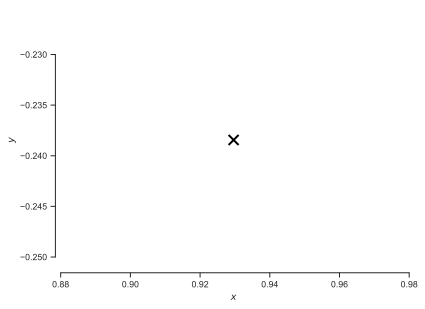

In [2]:
def f(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)
X = np.random.rand(1)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);


/opt/anaconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


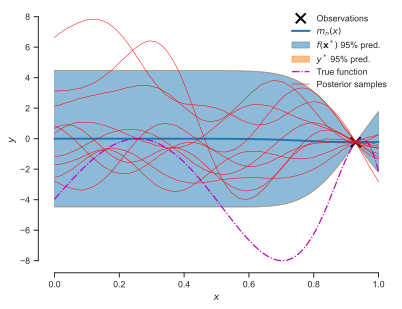

In [3]:
#converts numpy array X into tensor of type float32 so GPytorch can handle it
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

#creates an instance of ExactGP which is a subclass of gypyroch.models.ExactGP
model = ExactGP(train_x, train_y)


#normally in GPs we would optimize the hyperparameters such as:
    #lengthscale: controlling how far apart data points can be in order to be uncorrelated
    #outputscale: controls the variance of the function output
    #likelihood noise: controls how muhc noise we assume in the observations

# It is not a good idea to train the model when we don't have enough data (prevent overfitting)
# So we fix the hyperparameters to something reasonable

model.covar_module.base_kernel.lengthscale = .15
model.covar_module.outputscale = 5.
model.likelihood.noise = 0.0

#switching to evaluation mode
#this is necessary before making predictions with a trained GP model
model.eval()

#generate 100 evenly spaced points btw 0 and 1
x = torch.linspace(0, 1, 100)


plot_1d_regression(

    #x: the test points we want to evaluate the GP
    #model: the GP model that will generate predictions
    #f_true = f: if a true functino exists, it will be plotted for comparison
    x,
    model,
    f_true=f,
);

In [4]:
def poi(m, sigma, ymax, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration. larger psi means more exploration
    """
    return torch.distributions.Normal(0, 1).cdf((m - ymax - psi) / sigma)

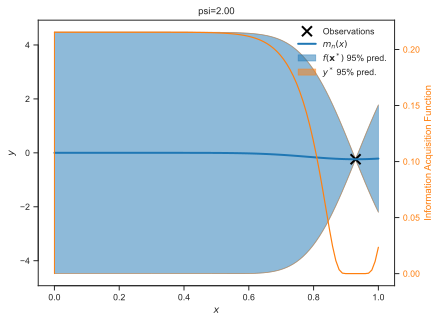

In [5]:
plot_iaf(x,model,poi,alpha_params=dict(psi=2.0))

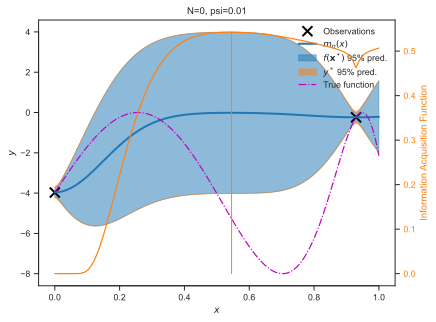

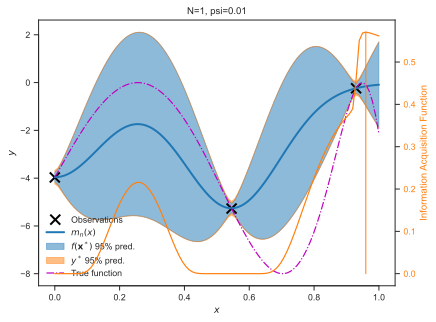

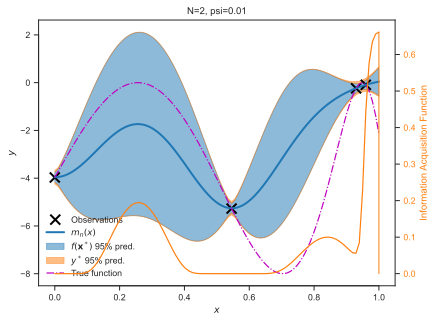

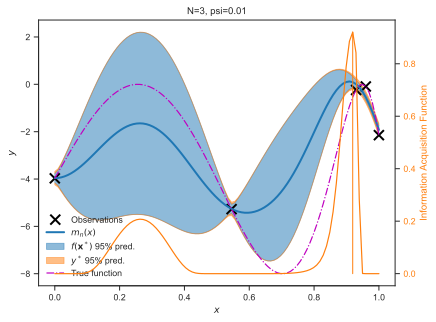

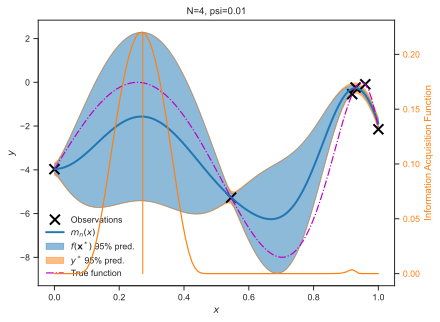

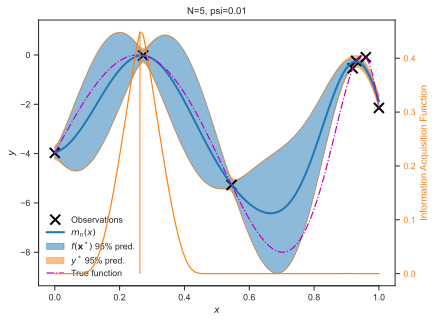

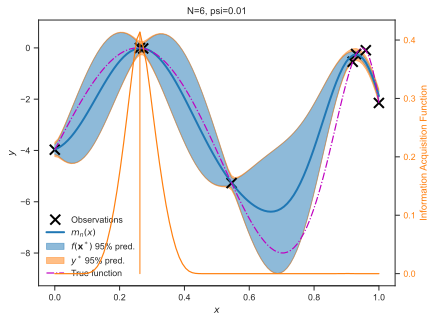

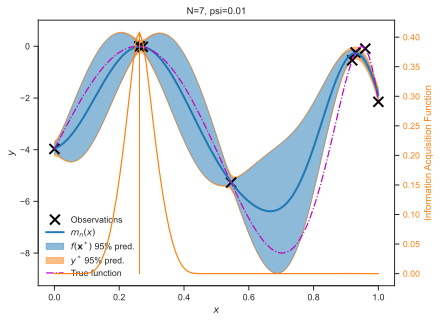

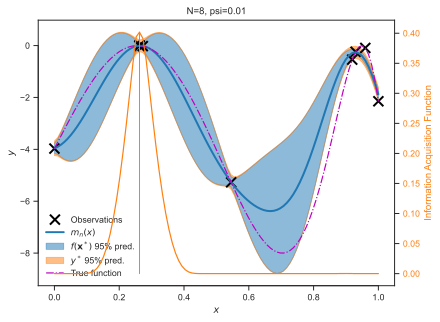

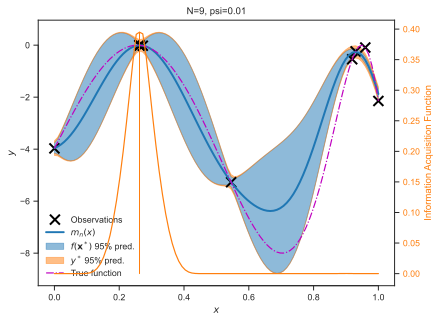

In [6]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
covar_module = ScaleKernel(RBFKernel())
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 1e-2
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(
    f,
    model,
    X_design,
    poi,
    alpha_params=dict(psi=.01),
    max_it=10,
    plot=1
)

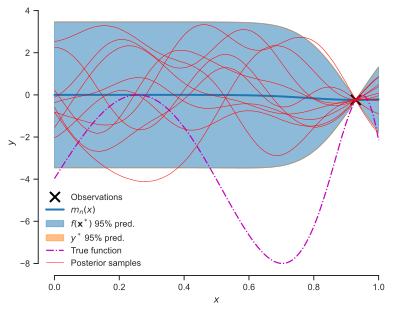

In [7]:
train_x1 = torch.from_numpy(X).float()
train_y1 = torch.from_numpy(Y).float()
model1 = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model1.covar_module.base_kernel.lengthscale = 0.15
model1.covar_module.outputscale = 3.
model1.likelihood.noise = 0.0
model1.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model1,
    f_true=f
);

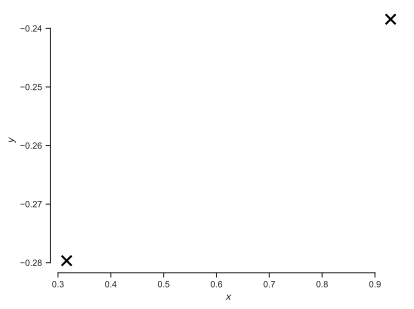

In [8]:
def g(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 2

X = np.random.rand(n_init)
Y = g(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

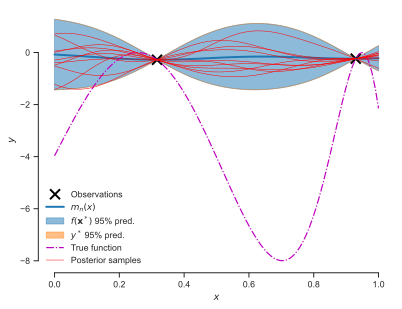

In [9]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.2
model.covar_module.outputscale = .5
model.likelihood.noise = 0.0
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model,
    f_true=f
);

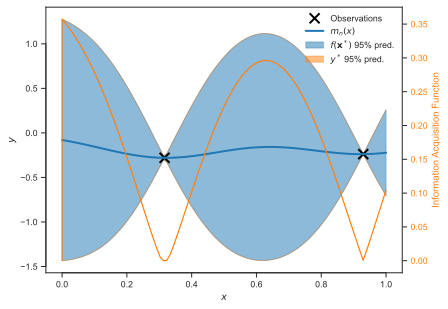

In [10]:
def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) + 
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

plot_iaf(
    x,
    model,
    ei
)

/opt/anaconda3/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


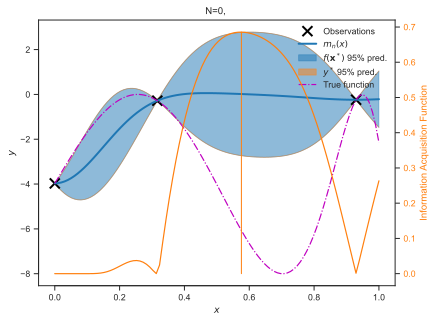

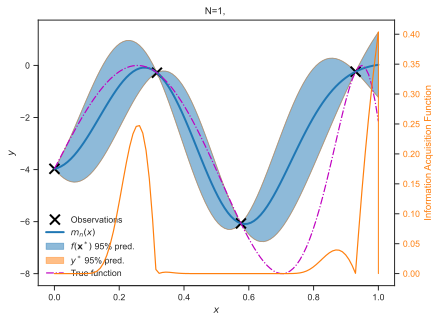

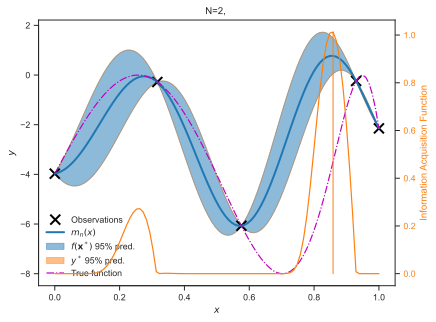

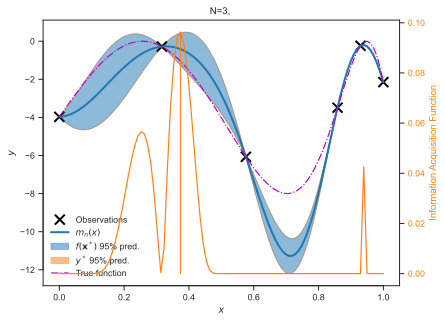

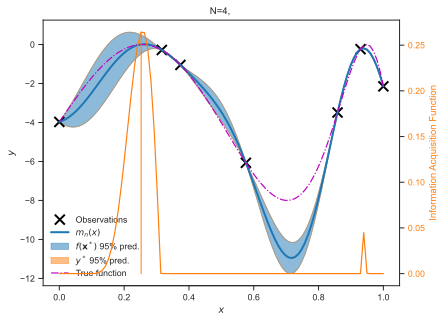

In [11]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 2.0
model.likelihood.noise = 0.0
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(
    f,
    model,
    X_design,
    ei,
    max_it=5,
    plot=1
)